In [2]:
torch.setdefaulttensortype('torch.FloatTensor')

### Load SB dataset

In [3]:
require 'paths'
require 'image'

-- relative = '/home/shrubb/Documents/BKP/Datasets/StanfordBkgd/'
relative = '../Datasets/StanfordBkgd/'
labels = torch.load(relative .. 'labels_th.t7'):add(1):byte()
images = torch.FloatTensor(labels:size(1), 3, 240, 320)

collectgarbage()

filenames = {}
for file in paths.files(relative .. 'images_resized/') do
    if file:byte() ~= 46 then
        table.insert(filenames, file)
    end
end

table.sort(filenames)

for id, file in ipairs(filenames) do
    images[id]:copy(image.load(relative .. 'images_resized/' .. file))
end

-- labels:apply(function(x) return x == 0 and 2 or x end)

mean = images:mean()
std = images:std()

images:add(-mean)
images:div(std)

collectgarbage()

### Render labels for displaying

In [4]:
function renderLabels(labels, img)
    local LUT = {
        [0] = {0.0, 0.0, 0.0}, -- void
        [1] = {0.0, 1.0, 1.0}, -- sky
        [2] = {1.0, 1.0, 0.0}, -- tree
        [3] = {0.5, .25, 0.5}, -- road
        [4] = {0.0, 1.0, 0.0}, -- grass
        [5] = {0.0, 0.0, 1.0}, -- water
        [6] = {0.5, 0.0, 0.0}, -- building
        [7] = {1.0, 1.0, 1.0}, -- mountain
        [8] = {1.0, 0.0, 0.0}  -- foreground object
    }
    
    local retval = torch.FloatTensor(3, 240, 320)
    for i = 1,240 do
        for j = 1,320 do
            if not LUT[labels[i][j]] then
                print(labels[i][j], i, j)
            end
            for k, color in ipairs(LUT[labels[i][j]]) do
                retval[k][i][j] = color
            end
        end
    end
    
    if img then
        local labelsBlendCoeff = 0.62
        img = img:clone()
        img:add(-img:min())
        img:div(img:max())
        retval:mul(labelsBlendCoeff)
        retval:add(img * (1 - labelsBlendCoeff))
    end
    
    return retval
end

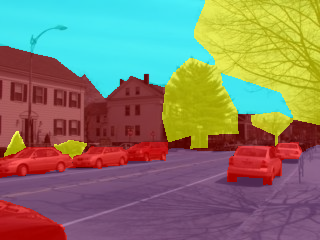

In [4]:
-- example blending
local k = 55
itorch.image(renderLabels(labels[k], images[k]))

In [5]:
function jitterScale(img, labelsMat)
    local scaleDiffFactor = math.random() * 0.09 - 0.045 -- originally +/- 10%
    local heightDiff = math.floor(img:size(2) * scaleDiffFactor)
    local widthDiff = math.floor(img:size(3) * scaleDiffFactor)
    local padder = 
        nn.SpatialZeroPadding(widthDiff, widthDiff, heightDiff, heightDiff)

    local imgScaled = image.scale(padder:forward(img), 320, 240, 'bilinear')
    local labelsMatScaled = 
        image.scale(
            padder:forward(labelsMat:view(1, 240, 320)), 320, 240, 'simple')

    return imgScaled, labelsMatScaled:view(240, 320)
end

function jitter(img, labelsMat, flip)
    local imgFlipped, labelsMatFlipped

    if flip then
        imgFlipped = image.flip(img, 3)
        labelsMatFlipped = image.flip(labelsMat, 2)
    end

    local angle = (math.random() - 0.5) * (math.pi / 180 * 9)
    local imgRotated = image.rotate(imgFlipped or img, angle, 'bilinear')
    local labelsMatRotated = 
        image.rotate(labelsMatFlipped or labelsMat, angle, 'simple')

    return jitterScale(imgRotated, labelsMatRotated)
end

In [6]:
CUDA = true

In [7]:
Integral = nil
debug.getregistry()['Integral'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil

require 'Integral-cuda-multi'

In [8]:
net = torch.load('SB segmentation 2/net.t7')
losses = torch.load('SB segmentation 2/loss-history.t7')

In [64]:
net = nn.Sequential()

convPlusInt = nn.Concat(1)
convPlusInt:add(Integral(12, 240, 320))
convPlusInt:add(nn.SpatialConvolutionMM(3, 3*12, 3,3, 1,1, 1,1))
net:add(convPlusInt) -- 3 -> 72

net:add(nn.LeakyReLU(0.01))
net:add(nn.SpatialConvolutionMM(72, 12, 1,1,1,1)) -- 72 -> 12

convPlusInt2 = nn.Concat(1)
convPlusInt2:add(Integral(8, 240, 320))
convPlusInt2:add(nn.SpatialConvolutionMM(12, 12*6, 3,3, 1,1, 1,1))
net:add(convPlusInt2) -- 12 -> 168

net:add(nn.LeakyReLU(0.01))
net:add(nn.SpatialConvolutionMM(168, 8, 1,1,1,1)) -- 168 -> 8

net:add(nn.Reshape(8, 240*320))
net:add(nn.Transpose({2, 1}))

if CUDA then
    require 'cunn'
    net:cuda()
end

In [14]:
params, gradParams = net:parameters()

In [15]:
local function calcClassWeights(labels)
    local counts = {}
    labels:apply(function(x) counts[x] = (counts[x] or 0) + 1 end)
    counts[0] = nil

    local sum = 0
    for k, v in pairs(counts) do
        sum = sum + v
    end

    for k, v in pairs(counts) do
        counts[k] = sum / v -- inverse frequency
    end

    local classWeights = torch.Tensor(counts)
    classWeights:div(classWeights:mean())
    return classWeights
end

criterion = nn.CrossEntropyCriterion(calcClassWeights(labels)):type(net:type())

In [16]:
require 'optim'

datasetIdx = 1

optimStates = {}

for i = 1,#params do
    local lr = 1.08e-3
    if i <= 4 or (i >= 9 and i <= 12) then
        lr = 0.7
    end
    
    optimStates[i] = {
        learningRate = lr,
        learningRateDecay = 0.99945,
        momentum = 0.9
    }
end

In [17]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

windowDebugger_1 = WindowDebugger()
windowDebugger_2 = WindowDebugger()

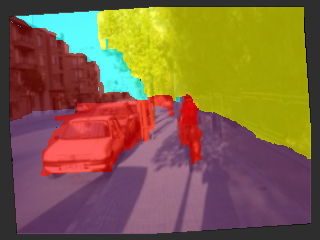

In [32]:
k =400
img, lab = jitter(images[k], labels[k], true)
itorch.image(renderLabels(lab, img))

In [18]:
require 'gnuplot'

function plotLosses(losses)
    gnuplot.figure(1)
    gnuplot.plot(torch.Tensor(losses), '-')
    gnuplot.axis{1, #losses, 0.4, 2.05}
    gnuplot.xlabel('Iteration')
    gnuplot.ylabel('Loss')
end

In [13]:
losses = {}

In [ ]:
batchSize = 10
shuffleData = true
shuffleEvery = math.ceil(images:size(1) / batchSize) -- shuffle data every `shuffleEvery` iterations
outputFreq = 1 -- how often to output loss to `losses` table and to redraw loss graph
saveFreq = 12 -- how oftern to save `net` and `windowDebugger`s

function randomShuffle(t)
  for i = 1,#t do
    local j = math.random(i, #t)
    t[i], t[j] = t[j], t[i]
  end
end

idx = {}
for i = 1,images:size(1) do
    idx[i] = i
end

local avgLoss = 0

for iter = 1,97 do
    
    if (iter-1) % shuffleEvery == 0 then
        randomShuffle(idx)
        print('Epoch ' .. ((iter-1) / shuffleEvery))
    end
    
    windowDebugger_1:add(net:get(1):get(1))
    windowDebugger_2:add(net:get(4):get(1))
    
    local batchLoss = 0 -- at current minibatch
    
    -- forward + backward
    do
        net:zeroGradParameters()

        for k = 1,batchSize do

            local input, target = jitter(
                images[idx[datasetIdx]], 
                labels[idx[datasetIdx]], 
                torch.random() % 2 == 0)
            
            target = target:view(240*320)

            input = input:type(net:type())
            local outputs = net:forward(input)

            for i = 1,target:nElement() do
                if target[i] == 0 then
                    target[i] = 3
                    outputs[i]:zero()
                    outputs[{i,3}] = 1e4
                end
            end
            
            target = target:type(net:type())

            batchLoss = batchLoss + criterion:forward(outputs, target)
            local dLoss_dOutputs = criterion:backward(outputs, target)
            net:backward(input, dLoss_dOutputs, 1/batchSize) -- accumulate gradients
            
            datasetIdx = datasetIdx % labels:size(1) + 1
        end
        
        batchLoss = batchLoss / batchSize
    end
    
    avgLoss = avgLoss + batchLoss
    
    -- optimization step
    for i = 1,#params do
        local feval = function(x)
            return batchLoss, gradParams[i]
        end

        if iter < 13 and i == 1 then
            print('Param:' .. params[i][1])
--             print('Real param:' .. net:get(1):get(1).xMin[1])
--             print('Grad:' .. gradParams[i][1])
--             print('Real grad:' .. net:get(1):get(1).gradXMin[1])
--             print(torch.data(params[i]), torch.data(net:get(1):get(1).xMin))
        end
        optim.adam(feval, params[i], optimStates[i])
--         if iter < 13 and i == 1 then
--             print(torch.data(params[i]), torch.data(net:get(1):get(1).xMin))
--             print('Params after LR = ' .. optimStates[i].learningRate .. ':')
--             print('Param:' .. params[i][1])
--             print('Real param:' .. net:get(1):get(1).xMin[1])
--             print('')
--         end
    end

    collectgarbage()

    if iter % outputFreq == 0 then
        losses[#losses+1] = avgLoss / outputFreq
        avgLoss = 0
        
        plotLosses(losses)
    end
    
    if (iter-1) % saveFreq == 0 then
        net:clearState()
        torch.save('SB segmentation/net.t7', net)
        torch.save('SB segmentation/loss-history.t7', losses)
        windowDebugger_1:exportVideo('SB segmentation/int-layer-1.avi')
        windowDebugger_2:exportVideo('SB segmentation/int-layer-2.avi')
    end
    
    if (iter-4) % 4 == 0 then
        print(
            'Iteration ' .. iter ..
            ', loss = ' .. (losses[#losses] or 0) .. ', ' .. os.date()
        )
    end
end

Epoch 0	


In [19]:
function predict(net, example)
    local pred = net:forward(example:type(net:type()))
    return select(2, pred:view(240, 320, 8):max(3)):squeeze():float()
end

function comparePredictions(img, labels, net, omitOriginal)
    img = img:clone()
    prediction = predict(net, img)
    
    img:add(-img:min())
    img:div(img:max())
    
    local retval
    
    if omitOriginal then
        retval = torch.ones(3, img:size(2), img:size(3)*2 + 2)

        retval[{{}, {}, {1, img:size(3)}}]:copy(renderLabels(labels, img))
        retval[{{}, {}, {img:size(3)+3, img:size(3)*2+2}}]:copy(renderLabels(prediction, img))
    else
        retval = torch.ones(3, img:size(2), img:size(3)*3 + 4)
        retval[{{}, {}, {1, img:size(3)}}]:copy(img)
        retval[{{}, {}, {img:size(3)+3, img:size(3)*2+2}}]:copy(renderLabels(labels, img))
        retval[{{}, {}, {img:size(3)*2+5, retval:size(3)}}]:copy(renderLabels(prediction, img))
    end
    
    return retval
end

In [90]:
for i = 1,27 do
    local k = torch.random(715)
    image.savePNG(string.format('SB segmentation/Images/%03d.png', k), comparePredictions(images[k], labels[k], net))
end